# Clean MRI data

In [ ]:
# first, load some necessary libraries
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread
import matplotlib.image as mpimg

In [54]:
# define useful file paths:
data_path = './manifest-1654812109500/'
boxes_path = './Annotation_Boxes.xlsx'
mapping_path = './Breast-Cancer-MRI-filepath_filename-mapping.xlsx'
target_png_dir = './png_out'

if not os.path.exists(target_png_dir):
    os.makedirs(target_png_dir)

In [104]:
# load the bounding box annotation list and see what it looks like
boxes_df = pd.read_excel(boxes_path)
boxes_df['ID_Number'] = boxes_df['Patient ID'].apply(lambda x: x.split('_')[-1])
boxes_df = boxes_df.set_index("ID_Number")
display(boxes_df) # needs to be in .ipynb/IPython notebook to work

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
ID_Number,,,,,,,
001,Breast_MRI_001,234,271,308,341,89,112
002,Breast_MRI_002,251,294,108,136,59,72
003,Breast_MRI_003,351,412,82,139,96,108
004,Breast_MRI_004,262,280,193,204,86,95
005,Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...,...
918,Breast_MRI_918,345,395,338,395,62,85
919,Breast_MRI_919,285,312,369,397,98,109
920,Breast_MRI_920,172,193,337,355,87,101


In [6]:
mapping_df = pd.read_excel(mapping_path) 
mapping_df = mapping_df.loc[:, ~mapping_df.columns.str.contains('^Unnamed')]
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains('post_3')]

In [7]:
# remove entries from patients that we are not including (we only include patients 1 to 100)
# using a regex pattern
crossref_pattern = '|'.join(["DICOM_Images/Breast_MRI_{:03d}".format(s) for s in list(range(1, 310))])
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains(crossref_pattern)]

In [9]:
def save_dcm_slice(dcm_fname, label, vol_idx):        
    # create a path to save the slice .png file in, according to the original DICOM filename and target label
    
        # take last element of "dcm_fname" after '/' as seperator and replace 'dcm ending with '-{}.png' 
    png_path = dcm_fname.split('/')[-1].replace('.dcm', '-{}.png'.format(vol_idx))
    label_dir = 'pos' if label == 1 else 'neg'
    png_path = os.path.join(target_png_dir, label_dir, png_path)

    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))

    if not os.path.exists(png_path):
        # only make the png image if it doesn't already exist (if you're running this after the first time)

        # load DICOM file with pydicom library
        try:
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            # fix possible errors in filename from list
            dcm_fname_split = dcm_fname.split('/')
            dcm_fname_end = dcm_fname_split[-1]
            assert dcm_fname_end.split('-')[1][0] == '0'

            dcm_fname_end_split = dcm_fname_end.split('-')
            dcm_fname_end = '-'.join([dcm_fname_end_split[0], dcm_fname_end_split[1][1:]])

            dcm_fname_split[-1] = dcm_fname_end
            dcm_fname = '/'.join(dcm_fname_split)
            dcm = pydicom.dcmread(dcm_fname)


        # convert DICOM into numerical numpy array of pixel intensity values (-> normalisation)
        img = dcm.pixel_array

        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(float) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img = np.invert(img)
        # save final .png
        imsave(png_path, img)
        

In [10]:
mapping_df["slice_idx"] = mapping_df['original_path_and_filename'].apply(lambda x: int(((x.split('/')[-1]).split('_')[-1]).replace('.dcm', '')))

In [22]:
mapping_df["slice_idx"]

320         1
321         2
322         3
323         4
324         5
         ... 
259222    188
259223    189
259224    190
259225    191
259226    192
Name: slice_idx, Length: 51840, dtype: int64

In [12]:
mapping_df["patient_no"] = mapping_df["descriptive_path"].apply(lambda x: x.split("/")[1])

In [14]:
mapping_df.groupby("patient_no").apply(lambda x: x.sample(1)).reset_index(drop=True)

,sop_instance_UID,original_path_and_filename,classic_path,descriptive_path,series_sort,slice_idx,patient_no
0,1.3.6.1.4.1.14519.5.2.1.1199553116916168344379...,DICOM_Images/Breast_MRI_001/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,73,BreastMRI001
1,1.3.6.1.4.1.14519.5.2.1.1298007996696187214553...,DICOM_Images/Breast_MRI_002/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_002/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI002/01-01-1990...,NaN,122,BreastMRI002
2,1.3.6.1.4.1.14519.5.2.1.2884813336059298264643...,DICOM_Images/Breast_MRI_003/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_003/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI003/01-01-1990...,NaN,121,BreastMRI003
3,1.3.6.1.4.1.14519.5.2.1.6142205136140254237552...,DICOM_Images/Breast_MRI_004/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_004/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI004/01-01-1990...,NaN,76,BreastMRI004
4,1.3.6.1.4.1.14519.5.2.1.1812695149439520969523...,DICOM_Images/Breast_MRI_005/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_005/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI005/01-01-1990...,NaN,43,BreastMRI005
...,...,...,...,...,...,...,...
299,1.3.6.1.4.1.14519.5.2.1.2803588218264476961799...,DICOM_Images/Breast_MRI_305/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_305/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI305/01-01-1990...,NaN,15,BreastMRI305
300,1.3.6.1.4.1.14519.5.2.1.2869764769712528670370...,DICOM_Images/Breast_MRI_306/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_306/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI306/01-01-1990...,NaN,85,BreastMRI306
301,1.3.6.1.4.1.14519.5.2.1.5389796266742477047041...,DICOM_Images/Breast_MRI_307/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_307/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI307/01-01-1990...,NaN,174,BreastMRI307
302,1.3.6.1.4.1.14519.5.2.1.1985002847700172128296...,DICOM_Images/Breast_MRI_308/post_3/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_308/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI308/01-01-1990...,NaN,18,BreastMRI308


In [26]:
import matplotlib.pylab as plt 
from matplotlib.patches import Rectangle

In [91]:
first_row = mapping_df.iloc[0]
dcm_fname = 'Duke-Breast-Cancer-MRI/Breast_MRI_264/01-01-1990-NA-MRI BREAST BILATERAL W/ & WO-11702/603.000000-Ph3ax 3d dyn-88245/1-042.dcm'
dcm_fname = os.path.join(data_path, dcm_fname)
# b = dcm_fname.index("BreastMRI")
# dcm_fname = dcm_fname[:b]+dcm_fname[b:b+6]+'_'+dcm_fname[b+6:b+9]+'_'+dcm_fname[b+9:b+12]+dcm_fname[b+12:b+12+11]+'-NA'+dcm_fname[b+12+11:]
# dcm_fname = dcm_fname.replace("W/WO","WWO")
# dcm_fname = dcm_fname.replace("W + W/O","W  WO")
# dcm_fname = dcm_fname.replace("BREAST^ROUTINE","BREASTROUTINE")
# dcm_fname = dcm_fname.replace("e+1","e1")
# dcm_fname = dcm_fname.replace("BREAST^lesion","BREASTlesion")
# dcm_fname = dcm_fname.replace("W AND W/O","W AND WO")
# dcm_fname = dcm_fname.replace("Ph3/ax","Ph3ax")
# dcm_fname = dcm_fname.replace("Ph3/Ax","Ph3Ax")
dcm_fname = dcm_fname.replace("BREAST^GENERAL","BREASTGENERAL")
dcm_fname = dcm_fname.replace("//","/")
dcm_fname = dcm_fname.replace("W/ & WO", "W  WO")
print(dcm_fname)

./manifest-1654812109500/Duke-Breast-Cancer-MRI/Breast_MRI_264/01-01-1990-NA-MRI BREAST BILATERAL W  WO-11702/603.000000-Ph3ax 3d dyn-88245/1-042.dcm


In [85]:
path = './manifest-1654812109500/Duke-Breast-Cancer-MRI/Breast_MRI_264/01-01-1990-NA-MRI BREAST BILATERAL W/ & WO-11702/603.000000-Ph3ax 3d dyn-88245/1-042.dcm'
real = "./manifest-1654812109500/Duke-Breast-Cancer-MRI/Breast_MRI_176/01-01-1990-NA-BREASTGENERAL-54584/9.000000-ax dyn 3rd pass-39425/1-063.dcm"

In [93]:
os.path.exists(dcm_fname)

True

In [90]:
os.listdir("./manifest-1654812109500/Duke-Breast-Cancer-MRI/Breast_MRI_264/01-01-1990-NA-MRI BREAST BILATERAL W  WO-11702/603.000000-Ph3ax 3d dyn-88245")

['1-013.dcm',
 '1-007.dcm',
 '1-167.dcm',
 '1-173.dcm',
 '1-172.dcm',
 '1-166.dcm',
 '1-006.dcm',
 '1-012.dcm',
 '1-038.dcm',
 '1-004.dcm',
 '1-010.dcm',
 '1-158.dcm',
 '1-170.dcm',
 '1-164.dcm',
 '1-165.dcm',
 '1-171.dcm',
 '1-159.dcm',
 '1-011.dcm',
 '1-005.dcm',
 '1-039.dcm',
 '1-001.dcm',
 '1-015.dcm',
 '1-029.dcm',
 '1-175.dcm',
 '1-161.dcm',
 '1-149.dcm',
 '1-148.dcm',
 '1-160.dcm',
 '1-174.dcm',
 '1-028.dcm',
 '1-014.dcm',
 '1-016.dcm',
 '1-002.dcm',
 '1-162.dcm',
 '1-176.dcm',
 '1-163.dcm',
 '1-003.dcm',
 '1-017.dcm',
 '1-058.dcm',
 '1-070.dcm',
 '1-064.dcm',
 '1-138.dcm',
 '1-104.dcm',
 '1-110.dcm',
 '1-111.dcm',
 '1-105.dcm',
 '1-139.dcm',
 '1-065.dcm',
 '1-071.dcm',
 '1-059.dcm',
 '1-067.dcm',
 '1-073.dcm',
 '1-098.dcm',
 '1-113.dcm',
 '1-107.dcm',
 '1-106.dcm',
 '1-112.dcm',
 '1-099.dcm',
 '1-072.dcm',
 '1-066.dcm',
 '1-062.dcm',
 '1-076.dcm',
 '1-089.dcm',
 '1-116.dcm',
 '1-102.dcm',
 '1-103.dcm',
 '1-117.dcm',
 '1-088.dcm',
 '1-077.dcm',
 '1-063.dcm',
 '1-075.dcm',
 '1-06

In [94]:
# initialize iteration index of each patient volume
vol_idx = -1

count = 0
for row_idx, row in tqdm(mapping_df.iterrows()):
    # indices start at 1 here
#     print(row)
    new_vol_idx = int((row['original_path_and_filename'].split('/')[1]).split('_')[-1])
    slice_idx = int(((row['original_path_and_filename'].split('/')[-1]).split('_')[-1]).replace('.dcm', ''))

    # new volume: get tumor bounding box
    if new_vol_idx != vol_idx:
        box_row = boxes_df.iloc[[new_vol_idx-1]]
        start_slice = int(box_row['Start Slice'])
        end_slice = int(box_row['End Slice'])
        assert end_slice >= start_slice
    vol_idx = new_vol_idx

    # determine slice label:
    # (1) if within 3D box, save as positive
    if slice_idx == int((start_slice + end_slice)/2):
        count+=1
        # get DICOM filename
        dcm_fname = str(row['descriptive_path'])
        dcm_fname = os.path.join(data_path, dcm_fname)
        b = dcm_fname.index("BreastMRI")
        dcm_fname = dcm_fname[:b]+dcm_fname[b:b+6]+'_'+dcm_fname[b+6:b+9]+'_'+dcm_fname[b+9:b+12]+dcm_fname[b+12:b+12+11]+'-NA'+dcm_fname[b+12+11:]
        dcm_fname = dcm_fname.replace("W/WO","WWO")
        dcm_fname = dcm_fname.replace("W + W/O","W  WO")
        dcm_fname = dcm_fname.replace("BREAST^ROUTINE","BREASTROUTINE")
        dcm_fname = dcm_fname.replace("e+1","e1")
        dcm_fname = dcm_fname.replace("BREAST^lesion","BREASTlesion")
        dcm_fname = dcm_fname.replace("W AND W/O","W AND WO")
        dcm_fname = dcm_fname.replace("Ph3/ax","Ph3ax")
        dcm_fname = dcm_fname.replace("Ph3/Ax","Ph3Ax")
        dcm_fname = dcm_fname.replace("BREAST^GENERAL","BREASTGENERAL")
        dcm_fname = dcm_fname.replace("//","/")
        dcm_fname = dcm_fname.replace("W/ & WO", "W  WO")
        save_dcm_slice(dcm_fname, 1, row["patient_no"])


51840it [00:03, 16639.67it/s]


### Print out image with annotation boxes

In [123]:
pos_im_dir = "./png_out/pos/"
path = os.path.join(pos_im_dir, os.listdir(pos_im_dir)[5])
patient_id = path.split('-')[-1][9:12]

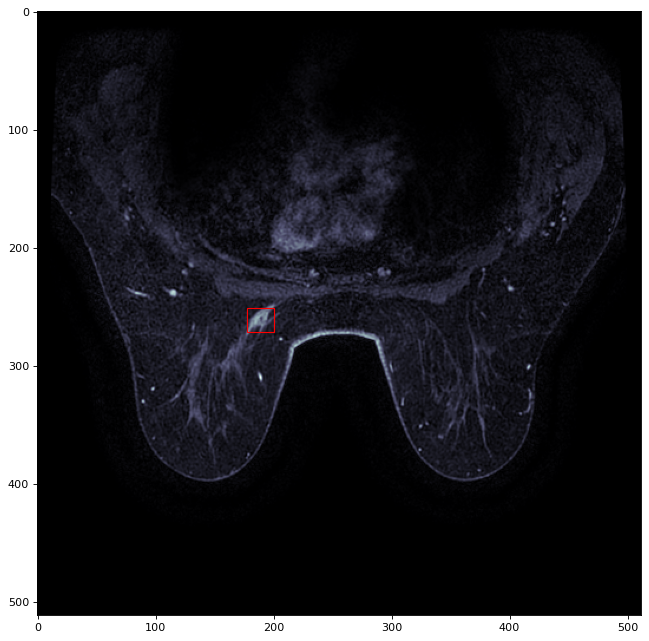

In [124]:
(start_r,
end_r,
start_c,
end_c) = (
    boxes_df.loc[patient_id, 'Start Row'],
    boxes_df.loc[patient_id, 'End Row'],
    boxes_df.loc[patient_id, 'Start Column'],
    boxes_df.loc[patient_id, 'End Column']
)

xy = (start_c,start_r) 
w = end_c - start_c
h = end_r - start_r

fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
img = mpimg.imread(path)
ax.imshow(img, cmap=plt.cm.bone)
rect = Rectangle(xy, w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()